In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

In [10]:
df = pd.read_excel("BaseFeaturesHH.xlsx")
df = df.drop('Unnamed: 0', axis = 1)
df

,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%)
0,2018-01-01 00:00:00,12.80,0,0.0,1,1,6.4,1.9,82.76
1,2018-01-01 00:30:00,12.30,0,0.5,1,1,6.4,1.9,82.76
2,2018-01-01 01:00:00,13.50,0,1.0,1,1,6.6,2.4,80.14
3,2018-01-01 01:30:00,11.90,0,1.5,1,1,6.6,2.4,80.14
4,2018-01-01 02:00:00,12.80,0,2.0,1,1,6.1,2.0,84.33
...,...,...,...,...,...,...,...,...,...
35035,2019-12-31 21:30:00,13.56,1,21.5,0,12,6.5,3.3,88.23
35036,2019-12-31 22:00:00,13.81,1,22.0,0,12,6.6,4.4,87.69
35037,2019-12-31 22:30:00,14.12,1,22.5,0,12,6.6,4.4,87.69
35038,2019-12-31 23:00:00,14.50,1,23.0,0,12,6.7,4.1,88.13


# 1. try adding weekend feature
From both datasets it seemed like the models, especially random forest was struggling with the weekends.


In [16]:
df['weekend'] = df['dayofweek']>4
df

,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%),weekend
0,2018-01-01 00:00:00,12.80,0,0.0,1,1,6.4,1.9,82.76,False
1,2018-01-01 00:30:00,12.30,0,0.5,1,1,6.4,1.9,82.76,False
2,2018-01-01 01:00:00,13.50,0,1.0,1,1,6.6,2.4,80.14,False
3,2018-01-01 01:30:00,11.90,0,1.5,1,1,6.6,2.4,80.14,False
4,2018-01-01 02:00:00,12.80,0,2.0,1,1,6.1,2.0,84.33,False
...,...,...,...,...,...,...,...,...,...,...
35035,2019-12-31 21:30:00,13.56,1,21.5,0,12,6.5,3.3,88.23,False
35036,2019-12-31 22:00:00,13.81,1,22.0,0,12,6.6,4.4,87.69,False
35037,2019-12-31 22:30:00,14.12,1,22.5,0,12,6.6,4.4,87.69,False
35038,2019-12-31 23:00:00,14.50,1,23.0,0,12,6.7,4.1,88.13,False


In [17]:
lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)', 'weekend']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting

size = -int(len(df)*0.2)

Xinput = df.iloc[:size]
Xtest = df.iloc[size:] # 20%

size2 = -int(len(Xinput)*0.25)

Xtrain = Xinput.iloc[:size2].copy() #60%
Xvalidate = Xinput.iloc[size2:].copy() #20%

trainX = Xtrain[feature_cols] # Features
trainy = Xtrain['HH Electricity (kWh)'] # Target variable

validateX = Xvalidate[feature_cols] # Features
validatey = Xvalidate['HH Electricity (kWh)'] # Target variable

testX = Xtest[feature_cols] # Features
testy = Xtest['HH Electricity (kWh)'] # Target variable

inputX = Xinput[feature_cols] # Features
inputy = Xinput['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
trainXscaled = scaler.transform(trainX)
validateXscaled = scaler.transform(validateX)
testXscaled = scaler.transform(testX)
inputXscaled = scaler.transform(inputX)



In [18]:
print(len(trainXscaled))
print(len(validateXscaled))
print(len(testXscaled))
print(len(inputXscaled))

20794
6931
6931
27725


# Random Forest Regressor

9.344111971935629


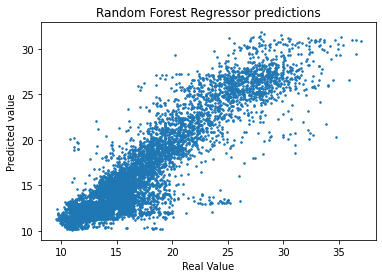

In [19]:
estimator = RandomForestRegressor(n_estimators = 1500,  random_state=42).fit(inputXscaled, inputy)
y_pred = estimator.predict(testXscaled)

RandomForestMAPE = mean_absolute_percentage_error(testy, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(testy,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

9.344111971935629


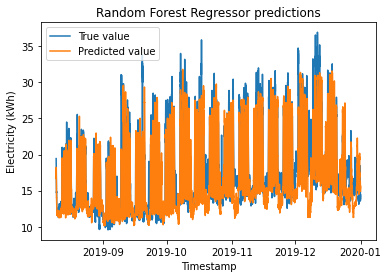

In [20]:
pred = estimator.predict(testXscaled)

RandomForestMAPE = mean_absolute_percentage_error(testy, pred) * 100
print(RandomForestMAPE)

plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
# show a legend on the plot
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()

In [23]:
df = pd.read_excel("BaseFeaturesDE.xlsx")
df = df.drop('Unnamed: 0', axis = 1)

In [24]:
df['weekend'] = df['dayofweek']>4
df

,From Timestamp,DE Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%),weekend
0,2018-05-10 09:30:00,332.0,3,9.5,0,5,12.0,12.0,61.88,False
1,2018-05-10 10:00:00,332.0,3,10.0,0,5,12.8,12.8,58.50,False
2,2018-05-10 10:30:00,334.0,3,10.5,0,5,12.8,12.8,58.50,False
3,2018-05-10 11:00:00,334.0,3,11.0,0,5,13.3,13.3,55.36,False
4,2018-05-10 11:30:00,337.0,3,11.5,0,5,13.3,13.3,55.36,False
...,...,...,...,...,...,...,...,...,...,...
28824,2019-12-31 21:30:00,227.0,1,21.5,0,12,6.5,3.3,88.23,False
28825,2019-12-31 22:00:00,227.0,1,22.0,0,12,6.6,4.4,87.69,False
28826,2019-12-31 22:30:00,226.0,1,22.5,0,12,6.6,4.4,87.69,False
28827,2019-12-31 23:00:00,228.0,1,23.0,0,12,6.7,4.1,88.13,False


In [25]:
lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['DE Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)', 'weekend']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting

size = -int(len(df)*0.2)

Xinput = df.iloc[:size]
Xtest = df.iloc[size:] # 20%

size2 = -int(len(Xinput)*0.25)

Xtrain = Xinput.iloc[:size2].copy() #60%
Xvalidate = Xinput.iloc[size2:].copy() #20%

trainX = Xtrain[feature_cols] # Features
trainy = Xtrain['DE Electricity (kWh)'] # Target variable

validateX = Xvalidate[feature_cols] # Features
validatey = Xvalidate['DE Electricity (kWh)'] # Target variable

testX = Xtest[feature_cols] # Features
testy = Xtest['DE Electricity (kWh)'] # Target variable

inputX = Xinput[feature_cols] # Features
inputy = Xinput['DE Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
trainXscaled = scaler.transform(trainX)
validateXscaled = scaler.transform(validateX)
testXscaled = scaler.transform(testX)
inputXscaled = scaler.transform(inputX)

5.34706297271891


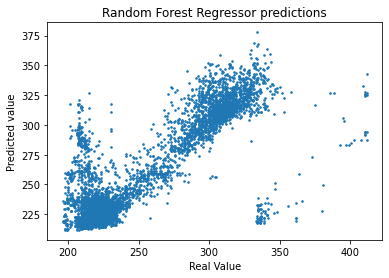

In [26]:
estimator = RandomForestRegressor(n_estimators = 1500,  random_state=42).fit(inputXscaled, inputy)
y_pred = estimator.predict(testXscaled)

RandomForestMAPE = mean_absolute_percentage_error(testy, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(testy,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

5.34706297271891


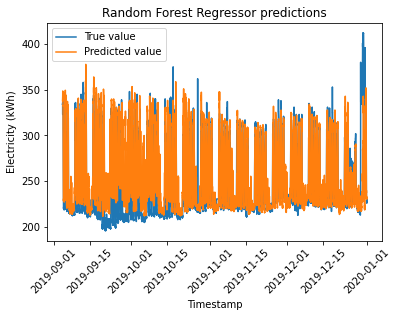

In [27]:
pred = estimator.predict(testXscaled)

RandomForestMAPE = mean_absolute_percentage_error(testy, pred) * 100
print(RandomForestMAPE)

plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()

2.8755869543565753


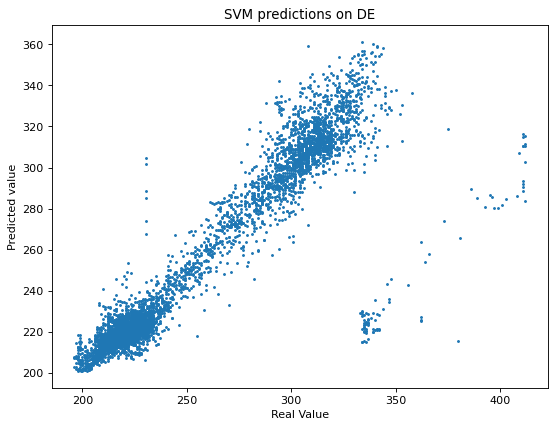

In [30]:
estimator = svm.SVR(C = 100,  kernel = 'rbf', epsilon = 1).fit(inputXscaled, inputy)
y_pred = estimator.predict(testXscaled)

SVMMAPE = mean_absolute_percentage_error(testy, y_pred) * 100
print(SVMMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(testy,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('SVM predictions on DE')
# Display a figure.
plt.show()

2.8755869543565753


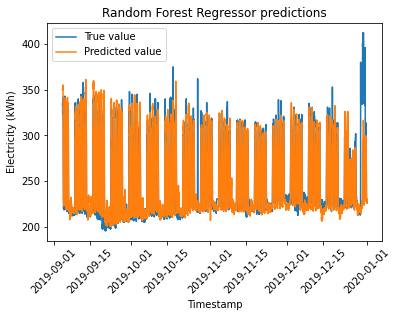

In [32]:
pred = estimator.predict(testXscaled)

RandomForestMAPE = mean_absolute_percentage_error(testy, pred) * 100
print(RandomForestMAPE)

plt.title('Random Forest Regressor predictions')
plt.plot(df['From Timestamp'].iloc[size:],testy, label = "True value")
plt.plot(df['From Timestamp'].iloc[size:],pred, label = "Predicted value")
plt.xticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('Electricity (kWh)')
plt.legend()

#### As we can see adding a weekend feature does not increase the model prediction accuracy.

# 2 Inspecting the distributions

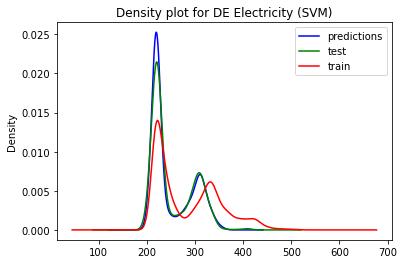

In [53]:
predictions = pd.DataFrame(pred, columns = ['predictions'])

predictions.plot.density(color='blue', label='predictions')
testy.plot.density(color='green', label='test')
inputy.plot.density(color='red', label='train')


plt.title('Density plot for DE Electricity (SVM)')
plt.legend()
plt.show()

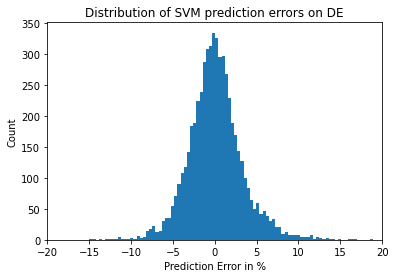

In [58]:
error = 100*(pred - testy)/testy
plt.hist(error, bins=200)
plt.title('Distribution of SVM prediction errors on DE')
plt.xlabel('Prediction Error in %')
plt.xlim([-20,20])
_ = plt.ylabel('Count')

# DE dataset seems to be OK. Given that the predictions are good I will not continue this in more depth. Instead I move on to HH

In [60]:
df = pd.read_excel("BaseFeaturesHH.xlsx")
df = df.drop('Unnamed: 0', axis = 1)

lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting

size = -int(len(df)*0.2)

Xinput = df.iloc[:size]
Xtest = df.iloc[size:] # 20%

size2 = -int(len(Xinput)*0.25)

Xtrain = Xinput.iloc[:size2].copy() #60%
Xvalidate = Xinput.iloc[size2:].copy() #20%

trainX = Xtrain[feature_cols] # Features
trainy = Xtrain['HH Electricity (kWh)'] # Target variable

validateX = Xvalidate[feature_cols] # Features
validatey = Xvalidate['HH Electricity (kWh)'] # Target variable

testX = Xtest[feature_cols] # Features
testy = Xtest['HH Electricity (kWh)'] # Target variable

inputX = Xinput[feature_cols] # Features
inputy = Xinput['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
trainXscaled = scaler.transform(trainX)
validateXscaled = scaler.transform(validateX)
testXscaled = scaler.transform(testX)
inputXscaled = scaler.transform(inputX)



In [61]:
estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(inputXscaled, inputy)
pred = estimator.predict(testXscaled)

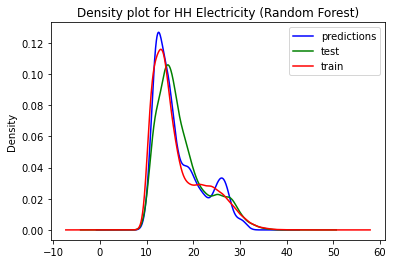

In [62]:
predictions = pd.DataFrame(pred, columns = ['predictions'])

predictions.plot.density(color='blue', label='predictions')
testy.plot.density(color='green', label='test')
inputy.plot.density(color='red', label='train')


plt.title('Density plot for HH Electricity (Random Forest)')
plt.legend()
plt.show()

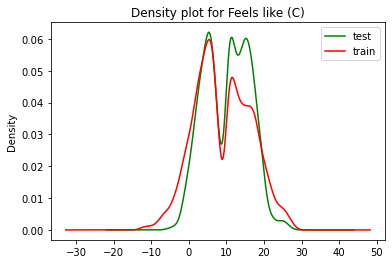

In [71]:
testX['Feels like (C)'].plot.density(color='green', label='test')
trainX['Feels like (C)'].plot.density(color='red', label='train')


plt.title('Density plot for Feels like (C)')
plt.legend()
plt.show()

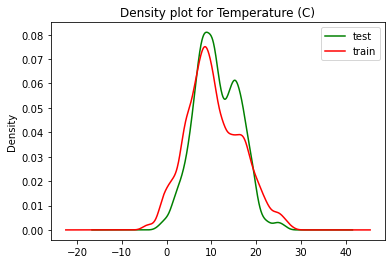

In [74]:
testX['Temperature (C)'].plot.density(color='green', label='test')
trainX['Temperature (C)'].plot.density(color='red', label='train')


plt.title('Density plot for Temperature (C)')
plt.legend()
plt.show()

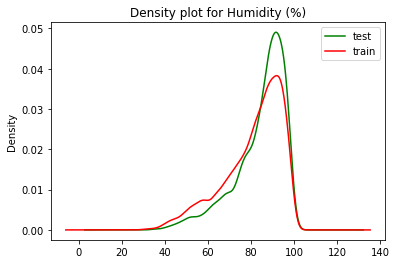

In [76]:
testX['Humidity '].plot.density(color='green', label='test')
trainX['Humidity'].plot.density(color='red', label='train')


plt.title('Density plot for Humidity (%)')
plt.legend()
plt.show()

# Random splitting

In [77]:
df = pd.read_excel("BaseFeaturesHH.xlsx")
df = df.drop('Unnamed: 0', axis = 1)

lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting
Y = df[['HH Electricity (kWh)']]


scaler = StandardScaler() #scaling
scaler.fit(X)
Xscaled = scaler.transform(X)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Xscaled,Y,test_size=0.20,random_state=42) #split training:testing 80:20

<ipython-input-79-ed12b10fd0af>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(X_train, y_train)


5.301960797789791


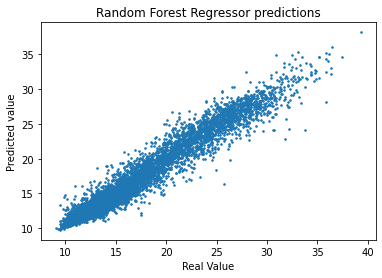

In [79]:
estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

RandomForestMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

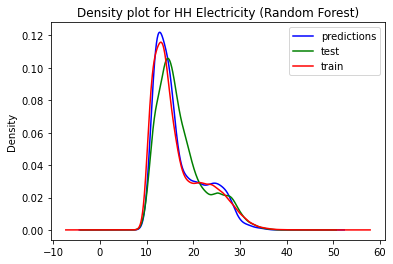

In [80]:
predictions = pd.DataFrame(y_pred, columns = ['predictions'])

predictions.plot.density(color='blue', label='predictions')
testy.plot.density(color='green', label='test')
inputy.plot.density(color='red', label='train')


plt.title('Density plot for HH Electricity (Random Forest)')
plt.legend()
plt.show()

# 3. Rounding values

<ipython-input-83-5420e6f6aac7>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(X_train, round(y_train))


5.573597682400077


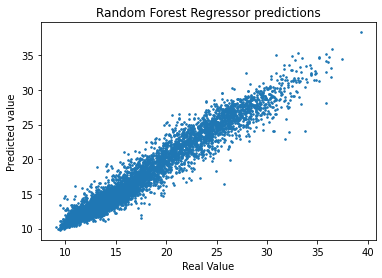

In [83]:
estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(X_train, round(y_train))
y_pred = estimator.predict(X_test)

RandomForestMAPE = mean_absolute_percentage_error(round(y_test), y_pred) * 100
print(RandomForestMAPE)

from matplotlib.figure import Figure as figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

##### Accuracy is worse now.

# 4. Shapley

In [5]:
import shap
shap.initjs()

In [6]:
df = pd.read_excel("BaseFeaturesHH.xlsx")
df = df.drop('Unnamed: 0', axis = 1)

lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting

size = -int(len(df)*0.2)

Xinput = df.iloc[:size]
Xtest = df.iloc[size:] # 20%

size2 = -int(len(Xinput)*0.25)

Xtrain = Xinput.iloc[:size2].copy() #60%
Xvalidate = Xinput.iloc[size2:].copy() #20%

trainX = Xtrain[feature_cols] # Features
trainy = Xtrain['HH Electricity (kWh)'] # Target variable

validateX = Xvalidate[feature_cols] # Features
validatey = Xvalidate['HH Electricity (kWh)'] # Target variable

testX = Xtest[feature_cols] # Features
testy = Xtest['HH Electricity (kWh)'] # Target variable

inputX = Xinput[feature_cols] # Features
inputy = Xinput['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
trainXscaled = scaler.transform(trainX)
validateXscaled = scaler.transform(validateX)
testXscaled = scaler.transform(testX)
inputXscaled = scaler.transform(inputX)


In [7]:
estimator = RandomForestRegressor(n_estimators = 1000,  random_state=42).fit(inputXscaled, inputy)
pred = estimator.predict(testXscaled)

RandomForestMAPE = mean_absolute_percentage_error(testy, pred) * 100
print(RandomForestMAPE)

9.355486354702085


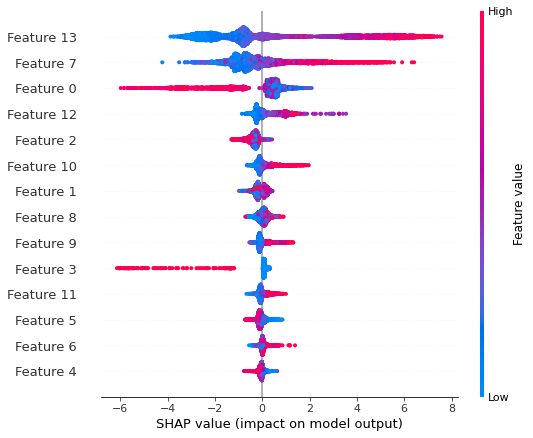

In [8]:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(testXscaled)

shap.summary_plot(shap_values, testXscaled)



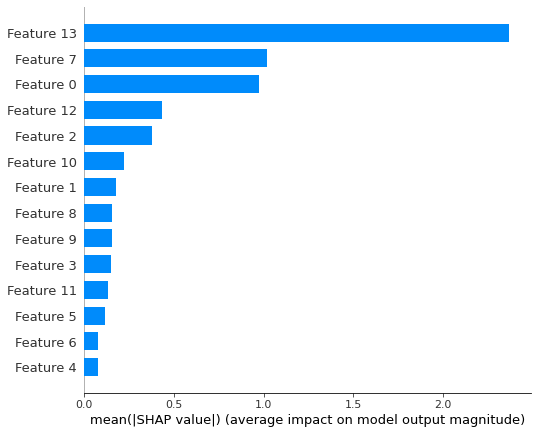

In [13]:
shap.summary_plot(shap_values, testXscaled, plot_type='bar')

# Local interpretability

A point where electricity should have increased due to lowered temperatures. As we can see temperature did not have an affect on the forecast unfortunately.

In [19]:
shap.force_plot(explainer.expected_value, shap_values[1486], features=testX.iloc[1486], feature_names=testX.columns)

In [25]:
pd.DataFrame([testX.columns, shap_values[1486]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,dayofweek,hour,month,holiday,Temperature (C),Feels like (C),Humidity (%),n-48.,n-96.,n-144.,n-192.,n-240.,n-288.,n-336.
1,1.25286,0.307609,-0.139772,0.154371,-0.083606,-0.108273,0.110874,-1.019907,0.020675,0.578259,0.408586,0.393039,1.175294,0.153262


According to SHAP values the temperature actually results in the value being less instead of increasing it as it should.

In [20]:
i = 1965
shap.force_plot(explainer.expected_value, shap_values[i], features=testX.iloc[i], feature_names=testX.columns)

### Normal Monday 13:30


In [26]:
i = 4510
shap.force_plot(explainer.expected_value, shap_values[i], features=testX.iloc[i], feature_names=testX.columns)

### Normal Wednesday 01:00

In [28]:
i = 4581
shap.force_plot(explainer.expected_value, shap_values[i], features=testX.iloc[i], feature_names=testX.columns)

### Sept Weekend

In [30]:
i = 765
shap.force_plot(explainer.expected_value, shap_values[i], features=testX.iloc[i], feature_names=testX.columns)

### Holiday

In [46]:
i = 6525
shap.force_plot(explainer.expected_value, shap_values[i], features=testX.iloc[i], feature_names=testX.columns)

In [47]:
i = 6565
shap.force_plot(explainer.expected_value, shap_values[i], features=testX.iloc[i], feature_names=testX.columns)

In [55]:
pd.DataFrame(shap_values[6590:6600], columns=testX.columns)


,dayofweek,hour,month,holiday,Temperature (C),Feels like (C),Humidity (%),n-48.,n-96.,n-144.,n-192.,n-240.,n-288.,n-336.
0,0.743577,-0.205246,-0.269917,0.062688,-0.045850,-0.081168,-0.014704,-1.071101,0.172389,-0.152514,0.029217,0.128954,0.650400,-0.717245
1,0.641060,-0.249970,-0.340090,0.056419,-0.039433,-0.060543,0.000918,-0.785494,0.117939,-0.220163,-0.029855,0.239575,0.300520,-0.569014
2,0.680304,-0.228309,-0.282701,0.059170,-0.042051,-0.059442,-0.001371,-0.994553,0.167487,-0.201597,-0.050342,0.163780,0.623745,-0.674391
3,0.607295,-0.258906,-0.317735,0.060522,-0.001916,-0.025920,0.034849,-1.088740,0.115789,-0.207102,-0.046949,0.137867,0.300712,-0.520073
4,0.544762,-0.241763,-0.319838,0.056629,0.002682,-0.018706,0.027140,-1.137745,0.191428,-0.165376,-0.073920,0.063649,0.137717,-0.567639
5,0.385984,-0.188380,-0.347179,-1.293868,0.034517,0.022959,0.006347,-0.970649,0.192519,-0.080749,-0.060995,0.051416,0.024132,-0.260273
6,0.398978,-0.187137,-0.356435,-1.278064,0.048482,0.005191,0.012167,-0.783553,0.235359,-0.106319,-0.048367,0.018227,0.049895,-0.210242
7,0.462355,-0.186837,-0.331583,-1.340889,0.054466,0.048639,0.019401,-0.620502,0.276324,-0.045651,-0.060646,0.092486,0.064383,-0.086184
8,0.460639,-0.184075,-0.319805,-1.311706,0.054398,0.048417,0.007615,-0.767974,0.317881,-0.029788,-0.043689,0.051522,0.052570,-0.091764
9,0.448950,-0.167686,-0.322238,-1.343978,0.074355,0.089118,0.018185,-0.714588,0.293469,-0.062925,-0.060169,0.029070,0.119150,-0.082012


In [56]:
i = 6620
shap.force_plot(explainer.expected_value, shap_values[i], features=testX.iloc[i], feature_names=testX.columns)

In [64]:
i = 1270
shap.force_plot(explainer.expected_value, shap_values[i], features=testX.iloc[i], feature_names=testX.columns)

## Inspecting temperature

In [84]:
df[(df['Temperature (C)']<-2) & (df['month']>9)]

,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%),n-48.,n-96.,n-144.,n-192.,n-240.,n-288.,n-336.
33750,2019-12-05 03:00:00,17.19,3,3.0,0,12,-2.1,-2.1,95.92,16.69,18.12,18.69,17.00,14.62,14.00,14.06
33751,2019-12-05 03:30:00,16.94,3,3.5,0,12,-2.1,-2.1,95.92,18.19,17.88,18.00,16.88,14.31,13.75,13.81


In [68]:
i = 2015
shap.force_plot(explainer.expected_value, shap_values[i], features=testX.iloc[i], feature_names=testX.columns)